https://github.com/mv-lab/AISP/tree/main/aim22-reverseisp/teams
https://github.com/mv-lab/AISP/tree/main/aim22-reverseisp/teams
https://github.com/mv-lab/AISP/tree/main/aim22-reverseisp/teams
https://github.com/mv-lab/AISP/tree/main/aim22-reverseisp/teams
https://github.com/mv-lab/AISP/tree/main/aim22-reverseisp/teams
https://github.com/mv-lab/AISP/tree/main/aim22-reverseisp/teams
https://github.com/mv-lab/AISP/tree/main/aim22-reverseisp/teams
https://github.com/mv-lab/AISP/tree/main/aim22-reverseisp/teams
https://github.com/mv-lab/AISP/tree/main/aim22-reverseisp/teams
# [AIM 2022](https://data.vision.ee.ethz.ch/cvl/aim22/) - Reverse ISP Challenge

### [Track 1 - S7](https://codalab.lisn.upsaclay.fr/competitions/5079)
### [Track 2 - HP20](https://codalab.lisn.upsaclay.fr/competitions/5080)


<img src=https://i.ibb.co/wgRBGQq/aim-challenge-teaser.jpg>


Digital cameras transform sensor RAW readings into RGB images by means of their Image Signal Processor (ISP). Computational photography tasks such as image denoising and colour constancy are commonly performed in the RAW domain, in part due to the inherent hardware design, but also due to the appealing simplicity of noise statistics that result from the direct sensor readings. Despite this, the availability of RAW images is limited in comparison with the abundance and diversity of available RGB data. Recent approaches have attempted to bridge this gap by estimating the RGB to RAW mapping.

In this challenge, we look for solutions to recover RAW readings from the camera using only the corresponding RGB images processed by the in-camera ISP. Successful solutions should generate plausible RAW images, and by doing this, other downstream tasks like Denoising, Super-resolution or Colour Constancy can benefit from such synthetic data generation.

## Datasets

**Samsung S7**

We use a custom version of the dataset collected by Schwartz et al. in their work *[DeepISP: Learning End-to-End Image Processing Pipeline](https://arxiv.org/abs/1801.06724)*. We process the original RAW images (GRBG pattern) and extract "aligned" RGB-RAW crop pairs.

**EH Huawei P20 Dataset**

We use a custom version of the dataset from [ETH PyNET by Ignatov et al.](http://people.ee.ethz.ch/~ihnatova/pynet.html#dataset), a large-scale dataset consisting of RAW-RGB image pairs captured in the wild with the Huawei P20 camera (12.3 MP Sony Exmor IMX380 sensor).
More information in their paper *[Replacing Mobile Camera ISP with a Single Deep Learning Model](https://arxiv.org/abs/2002.05509)*


In both tracks, we provide RAW and RGB images extracted from the camera ISP. 
- RAW images are provided in `.npy` format, as 4-channel images following the RGGB pattern
- RGB images are provided in `.jpg` format

You can download the competition data after registering at the challenge [here](https://codalab.lisn.upsaclay.fr/competitions/5079).

- Track 1 data is approx 3 Gb
- Track 2 data is approx 2.5 Gb

## Hints and Tips

- RAW images are provided as `np.uint16` with max value `2**10 = 1024`. 
- The RAW images are packed as (h,w,4) , you can unpack it and obtain a (h*2, w*2,1) RAW using the corresponding utils. We recommend to use the 4-channel RAW image.
- RAW images are already converted to standard RGGB pattern.
- Mosaic and Demosaic are provided for visualization purposes only.
- For the S7 dataset, most of the images are well-aligned, SSIM and PSNR should work as perceptual metrics.
- For the HP20 dataset, most of the images are **not** aligned. The RGB from the ISP is the process of many transformations includding cropping and zooming. Therefore we recomend perceptual losses as SSIM, MSSSIM and KL-Divergence. In this track, we focus on SSIM as standard metric, but we will consider internally the other mentioned metrics. 
- The ISP corrects many artifacts such as noise and blur. The original RAW images threfore might contain such artifacts.

In [1]:
!pip -q install gdown
!pip -q install rawpy

At the challenge website you can register and access to the data: https://codalab.lisn.upsaclay.fr/competitions/5079

The data sctructure should be as follows:

```
├── data-p20
│   ├── train
│   └── val_rgb
└── data-s7
    ├── train
    └── val_rgb
    
```

`data-p20` should be around 3 Gb and `data-s7` should be around 2.5 Gb

- `train/` contains RGBs in `.jpg` format and RAWs in `.npy` format
- `val_rgb/` contains RGBs in `.jpg`

From the corresponding RGBs, you need to reverse the ISP operations an provide the corresponding RAW image.

In [7]:
!du -sh data-p20 data-s7

3.2G	data-p20
2.5G	data-s7


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio
import rawpy
import sys
import os
import gc
import time
import random
from glob import glob
from tqdm import tqdm
from collections import defaultdict
from IPython import display
from skimage.metrics import mean_squared_error as MSE
from skimage.metrics import structural_similarity as SSIM

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam

torch.backends.cudnn.deterministic = True
device = torch.device("cuda")

print("CUDA visible devices: " + str(torch.cuda.device_count()))

D:\Tool\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


CUDA visible devices: 1


In [2]:
import pickle

# 加载元数据
with open(r"E:\rgb2raw\dataset\train\iphone-x\00.pkl", "rb") as f:
    metadata = pickle.load(f)
print("元数据内容:", metadata)

元数据内容: {'white_level': 4095, 'black_levels': [528, 528, 528, 528], 'camera_whitebalance': [1.754638671875, 1.0, 2.495361328125, 0.0], 'daylight_whitebalance': [2.5769433975219727, 0.997675895690918, 1.744163990020752, 0.0], 'color_matrix': array([[ 1.5755775 , -0.5263693 , -0.0492082 ,  0.        ],
       [-0.16799802,  1.528245  , -0.36024696,  0.        ],
       [ 0.03188488, -0.42302737,  1.3911425 ,  0.        ]],
      dtype=float32), 'cfa_pattern': [[0, 1], [3, 2]], 'sizes': {'raw_height': 3024, 'raw_width': 4032, 'height': 3024, 'width': 4032, 'top_margin': 0, 'left_margin': 0, 'iheight': 3024, 'iwidth': 4032, 'pixel_aspect': 1.0, 'flip': 6}, 'tone_curve': array([    0,     1,     2, ..., 65533, 65534, 65535], dtype=uint16)}


## 数据预处理

In [1]:
# import os
# import shutil
# from tqdm import tqdm

# # 定义原始目录和目标目录
# source_dirs = [
#     r"E:\rgb2raw\dataset\train\iphone-x",
#     r"E:\rgb2raw\dataset\train\lq-iphone",
#     r"E:\rgb2raw\dataset\train\lq-samsung",
#     r"E:\rgb2raw\dataset\train\samsung-s9"
# ]

# target_dir = r"E:\rgb2raw\data\train"

# # 确保目标目录存在
# os.makedirs(target_dir, exist_ok=True)

# # 初始化一个计数器，用于生成唯一的文件名
# file_counter = 0

# # 遍历每个源目录
# for source_dir in source_dirs:
#     # 用于存储已处理的文件对
#     processed_pairs = set()

#     # 获取目录中的所有文件
#     files = os.listdir(source_dir)
    
#     # 使用 tqdm 显示进度条
#     for file_name in tqdm(files, desc=f"Processing {source_dir}"):
#         # 检查文件名中是否包含下划线 '_'
#         if "_" not in file_name:
#             continue  # 如果没有下划线，跳过该文件
        
#         # 检查文件扩展名，确保只处理.npy和.png文件
#         if not file_name.endswith((".npy", ".png")):
#             continue
        
#         # 提取文件名的共同部分（例如 "0_0"）
#         base_name = os.path.splitext(file_name)[0]
        
#         # 如果文件对已经处理过，则跳过
#         if base_name in processed_pairs:
#             continue
        
#         # 构造文件对的完整路径
#         npy_file = f"{base_name}.npy" 
#         png_file = f"{base_name}.png"
        
#         # 检查文件对是否完整
#         if npy_file in files and png_file in files:
#             # 生成新的文件名（数字递增）
#             new_npy_name = f"{file_counter}.npy"
#             new_png_name = f"{file_counter}.png"
            
#             # 构造目标文件的完整路径
#             target_npy_path = os.path.join(target_dir, new_npy_name)
#             target_png_path = os.path.join(target_dir, new_png_name)
            
#             # 复制文件
#             shutil.copy2(os.path.join(source_dir, npy_file), target_npy_path)
#             shutil.copy2(os.path.join(source_dir, png_file), target_png_path)
            
#             # 更新计数器
#             file_counter += 1
            
#             # 标记文件对已处理
#             processed_pairs.add(base_name)

# print(f"所有符合条件的文件对已成功复制到 {target_dir}")

Processing E:\rgb2raw\dataset\train\samsung-s9: 100%|██████████████████████████████| 1184/1184 [01:39<00:00, 11.95it/s]

所有符合条件的文件对已成功复制到 E:\rgb2raw\data\train


### Utils+++++++++++++++

In [3]:
# Check https://github.com/mv-lab/AISP/utils.py for more utils for RAW image manipulation.

def load_img (filename, debug=False, norm=True, resize=None):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if norm:   
        img = img / 255.
        img = img.astype(np.float32)
    if debug:
        print (img.shape, img.dtype, img.min(), img.max())
        
    if resize:
        img = cv2.resize(img, (resize[0], resize[1]), interpolation = cv2.INTER_AREA)
        
    return img

def save_rgb (img, filename):
    if np.max(img) <= 1:
        img = img * 255
    
    img = img.astype(np.float32)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
    cv2.imwrite(filename, img)
    

def load_raw(raw, max_val=2**10):
    raw = np.load (raw)/ max_val
    return raw.astype(np.float32)


########## VISUALIZATION

def demosaic (raw):
    """Simple demosaicing to visualize RAW images
    Inputs:
     - raw: (h,w,4) RAW RGGB image normalized [0..1] as float32
    Returns: 
     - Simple Avg. Green Demosaiced RAW image with shape (h*2, w*2, 3)
    """
    
    assert raw.shape[-1] == 4
    shape = raw.shape
    
    red        = raw[:,:,0]
    green_red  = raw[:,:,1]
    green_blue = raw[:,:,2]
    blue       = raw[:,:,3]
    avg_green  = (green_red + green_blue) / 2
    image      = np.stack((red, avg_green, blue), axis=-1)
    image      = cv2.resize(image, (shape[1]*2, shape[0]*2))
    return image


def mosaic(rgb):
    """Extracts RGGB Bayer planes from an RGB image."""
    
    assert rgb.shape[-1] == 3
    shape = rgb.shape
    
    red        = rgb[0::2, 0::2, 0]
    green_red  = rgb[0::2, 1::2, 1]
    green_blue = rgb[1::2, 0::2, 1]
    blue       = rgb[1::2, 1::2, 2]
    
    image = np.stack((red, green_red, green_blue, blue), axis=-1)
    return image


def gamma_compression(image):
    """Converts from linear to gamma space."""
    return np.maximum(image, 1e-8) ** (1.0 / 2.2)

def tonemap(image):
    """Simple S-curved global tonemap"""
    return (3*(image**2)) - (2*(image**3))

def postprocess_raw(raw):
    """Simple post-processing to visualize demosaic RAW imgaes
    Input:  (h,w,3) RAW image normalized
    Output: (h,w,3) post-processed RAW image
    """
    raw = gamma_compression(raw)
    raw = tonemap(raw)
    raw = np.clip(raw, 0, 1)
    return raw

def plot_pair (rgb, raw, t1='RGB', t2='RAW', axis='off'):
    
    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.subplot(1,2,1)
    plt.title(t1)
    plt.axis(axis)
    plt.imshow(rgb)

    plt.subplot(1,2,2)
    plt.title(t2)
    plt.axis(axis)
    plt.imshow(raw)
    plt.show()

########## METRICS

def PSNR(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    if(mse == 0):  
        return np.inf
    
    max_pixel = np.max(y_true)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [4]:
def get_filenames(PATH):
    train_raws = sorted(glob(PATH + '/train/*.npy'))
    train_rgbs = sorted(glob(PATH + '/train/*.png'))
    valid_rgbs = sorted(glob(PATH + '/val/*'))
    assert len(train_raws) == len(train_rgbs)
    print (f'Training samples: {len(train_raws)} \t Validation samples: {len(valid_rgbs)}')
    return train_raws, train_rgbs, valid_rgbs

In [5]:
PATH    = f'data'

BATCH_TRAIN = 1
BATCH_TEST  = 1

# if DEBUG use only 250 datasamples, if not all the dataset
DEBUG = False 

train_raws, train_rgbs, valid_rgbs = get_filenames(PATH)

Training samples: 2454 	 Validation samples: 120


## Dataloader

In [6]:
class LoadData(Dataset):

    def __init__(self, root, rgb_files, raw_files=None, debug=False, test=None):
        
        self.root = root
        self.test = test
        self.rgbs = sorted(rgb_files)
        if self.test:
            self.raws = None
        else:
            self.raws = sorted(raw_files)
            
        self.debug = debug
        if self.debug:
            self.rgbs = self.rgbs[:100]
            self.raws = self.raws[:100]
        
    def __len__(self):
        return len(self.rgbs)

    def __getitem__(self, idx):

        rgb = load_img (self.rgbs[idx], norm=True)
        rgb = torch.from_numpy(rgb.transpose((2, 0, 1)))
        
        if self.test:
            return rgb, self.rgbs[idx]
        else:
            raw = load_raw (self.raws[idx])
            raw = torch.from_numpy(raw.transpose((2, 0, 1)))
            return rgb, raw

In [7]:
train_dataset = LoadData(root=PATH, rgb_files=train_rgbs,raw_files=train_raws, debug=DEBUG, test=False)
train_loader  = DataLoader(dataset=train_dataset, batch_size=BATCH_TRAIN, shuffle=True, num_workers=0,
                          pin_memory=True, drop_last=True)

test_dataset = LoadData(root=PATH, rgb_files=valid_rgbs, test=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=BATCH_TEST, shuffle=False, num_workers=0,
                         pin_memory=True, drop_last=False)

print (f'Train Dataloader BS={BATCH_TRAIN} N={len(train_loader)} / Test/Val Dataloader BS={BATCH_TEST} N={len(test_loader)}')

Train Dataloader BS=1 N=2454 / Test/Val Dataloader BS=1 N=120


In [8]:
## Sanity Check - OK

#train_loader = iter(train_loader)
#batch = train_loader.next()
#batch[0].shape, batch[1].shape

#for _rgb, _raw in zip(batch[0], batch[1]):
#    _rgb = _rgb.permute(1, 2, 0).numpy()
#    _raw = _raw.permute(1, 2, 0).numpy()
#    print (_rgb.shape, _raw.shape)
#    plot_pair(_rgb, postprocess_raw(demosaic(_raw)), t1=f'RGB', t2='RAW Demosaic')
#    break

## UNet++ model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size % 2 == 1, "Kernel size must be odd."
        self.conv1 = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 获取输入特征图的平均值和最大值
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        # 将平均值和最大值拼接
        x = torch.cat([avg_out, max_out], dim=1)
        # 通过卷积层生成空间注意力图
        x = self.conv1(x)
        # 使用Sigmoid函数将注意力图的值限制在[0, 1]范围内
        return self.sigmoid(x)

class ChannelAttention(nn.Module):
    def __init__(self, num_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(num_channels, num_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(num_channels // reduction_ratio, num_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class PositionAttention(nn.Module):
    def __init__(self, num_channels, reduction_ratio=16):
        super(PositionAttention, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, num_channels // reduction_ratio, kernel_size=1)
        self.conv2 = nn.Conv2d(num_channels, num_channels // reduction_ratio, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        m_batchsize, C, width, height = x.size()
        proj_query = self.conv1(x).view(m_batchsize, -1, width * height).permute(0, 2, 1)
        proj_key = self.conv2(x).view(m_batchsize, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = x.view(m_batchsize, -1, width * height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)
        out = self.gamma * out + x
        return out

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)
        self.cam = ChannelAttention(out_ch)
        #self.pam = PositionAttention(out_ch)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.cam(x)
        #x = self.pam(x)
        return x

class Encoder(nn.Module):
    def __init__(self, chs=(3, 64, 128, 256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)])
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64)):
        super().__init__()
        self.chs = chs
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i + 1], 2, 2) for i in range(len(chs) - 1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.chs) - 1):
            x = self.upconvs[i](x)
            enc_ftrs = encoder_features[i]
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.dec_blocks[i](x)
        return x

class UNet(nn.Module):
    def __init__(self, enc_chs=(3, 64, 128, 256), dec_chs=(256, 128, 64), out_ch=4, out_sz=(512, 512)):
        super().__init__()
        self.encoder = Encoder(enc_chs)
        self.decoder = Decoder(dec_chs)
        self.head = nn.Conv2d(dec_chs[-1], out_ch, 1)
        self.out_sz = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out = self.head(out)
        out = F.interpolate(out, self.out_sz)
        out = torch.clamp(out, min=0., max=1.)
        return out

## Training

In [10]:
class CFG:
    
    encoder = (3,64,128,256)
    decoder = (256, 128, 64)
    out_ch  = 4
    out_sz  = (512, 512)
    lr      = 1e-4
    lr_decay= 1e-6
    epochs  = 100
    loss    = nn.MSELoss()
    name    = 'unet-rev-isp.pt'
    out_dir = './out6'
    save_freq = 1

In [11]:
model = UNet(enc_chs=CFG.encoder, dec_chs=CFG.decoder, out_ch=CFG.out_ch, out_sz=CFG.out_sz)
# 加载权重文件
# pretrained_weights_path = r"E:\rgb2raw\out2\128.pt"
# model = torch.load(pretrained_weights_path, map_location=device, weights_only=False)
model = model.to(device)

opt   = torch.optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.lr_decay)

criterion = CFG.loss
metrics   = defaultdict(list)

In [12]:
len(metrics['train_loss'])

0

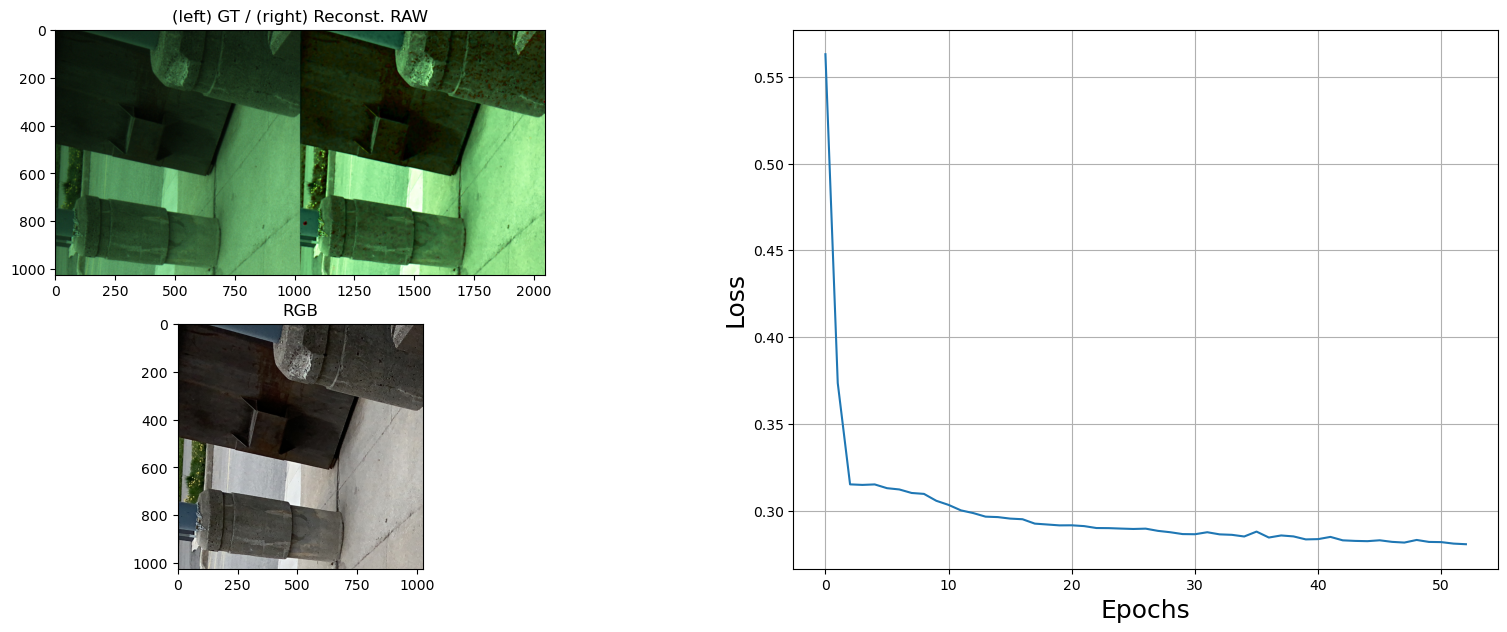

Epoch 53 of 100 took 563.267s



 88%|████████████████████████████████████████████████████████████████████▎         | 2151/2454 [08:30<01:16,  3.97it/s]

In [ ]:
min_loss = 1
min_loss_epoch = -1
for epoch in range(CFG.epochs):
    
    torch.cuda.empty_cache()
    start_time = time.time()
    train_loss = []

    model.train()
    
    for rgb_batch, raw_batch in tqdm(train_loader):
        opt.zero_grad()

        rgb_batch = rgb_batch.to(device)
        raw_batch = raw_batch.to(device)
        
        recon_raw = model(rgb_batch)

        loss = criterion(raw_batch, recon_raw)
        loss.backward()
        opt.step()

        train_loss.append(loss.item())

    now_loss = np.mean(train_loss)
    metrics['train_loss'].append(now_loss)
    if now_loss < min_loss:
        min_loss = now_loss
        min_loss_epoch = len(metrics['train_loss'])

    display.clear_output()
    plt.figure(figsize=(20, 7))
    ax1 = plt.subplot(2, 2, 1)
    reconst_raw = postprocess_raw(demosaic(recon_raw[-1].detach().cpu().permute(1, 2, 0).numpy()))
    gt_raw = postprocess_raw(demosaic(raw_batch[-1].detach().cpu().permute(1, 2, 0).numpy()))
    cmp_raw_gt = np.concatenate([gt_raw, reconst_raw], axis=1)
    ax1.imshow(cmp_raw_gt)
    ax1.set_title('(left) GT / (right) Reconst. RAW')

    ax2 = plt.subplot(2, 2, 3)
    ax2.imshow(rgb_batch[-1].detach().cpu().permute(1, 2, 0).numpy())
    ax2.set_title('RGB')

    ax3 = plt.subplot(1, 2, 2)
    #---------------------------------------------metrics['train_loss'] 里有 loss 数据---------------------------------------------
    ax3.plot(metrics['train_loss'], label='train')
    ax3.set_xlabel('Epochs', fontsize=18)
    ax3.set_ylabel('Loss', fontsize=18)
    ax3.grid()

    plt.show()

    print(f"Epoch {epoch + 1} of {CFG.epochs} took {time.time() - start_time:.3f}s\n")

    if ((epoch + 1) % CFG.save_freq == 0):
        torch.save(model, os.path.join(CFG.out_dir , f"{len(metrics['train_loss'])}.pt"))


torch.save(model.state_dict(), os.path.join(CFG.out_dir ,CFG.name))
print("最小的 loss 权重为：",min_loss_epoch, ".pt")

In [13]:
# 查看 loss
min_loss = 1
min_loss_epoch = -1
for i,v in enumerate(metrics['train_loss']):
    print(f"第{i+1}代:  ",v)
    if v < min_loss:
            min_loss = v
            min_loss_epoch = i

print(f"最小值为：{min_loss} ，它属于第 {min_loss_epoch+1} 代")

第1代:   0.19369170495067078
第2代:   0.19441896785204815
第3代:   0.19357930717755603
第4代:   0.19307769789228943
第5代:   0.19346164141795597
第6代:   0.1945465790791298
第7代:   0.19354277005699044
第8代:   0.19339160635914887
第9代:   0.1930692800662031
第10代:   0.19322467190607642
第11代:   0.1930772928127763
第12代:   0.19317488167514232
第13代:   0.19298706373325536
第14代:   0.19361273126231687
第15代:   0.19358453345865484
第16代:   0.1926467488757096
第17代:   0.1925152210890979
第18代:   0.19366753020996594
第19代:   0.19261414129312565
第20代:   0.19443919543957983
第21代:   0.1920175255189072
第22代:   0.1922569594886959
第23代:   0.19253892183361418
第24代:   0.19229484508118674
第25代:   0.19339115201983026
第26代:   0.19234597219085928
第27代:   0.19233878641649807
第28代:   0.19201944319667763
第29代:   0.19451755444170277
第30代:   0.19227150641209653
第31代:   0.1918090578492134
第32代:   0.1920829328613421
第33代:   0.19236991997080935
第34代:   0.1928487638028396
第35代:   0.19268455312106464
第36代:   0.19213373170983425
第37代:   0.1

## Submission

  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

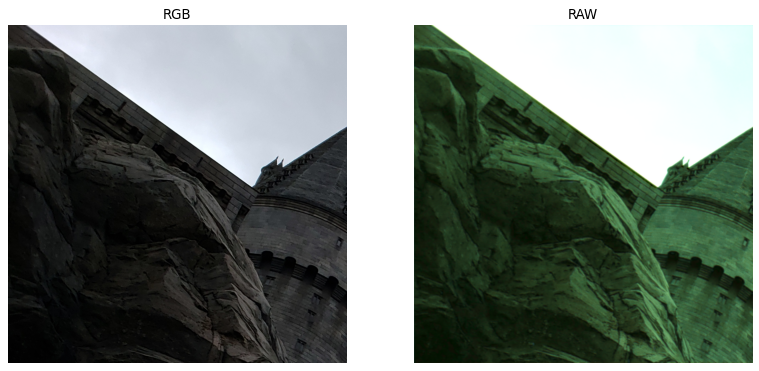

 83%|██████████████████████████████████████████████████████████████████▋             | 100/120 [00:13<00:02,  7.01it/s]

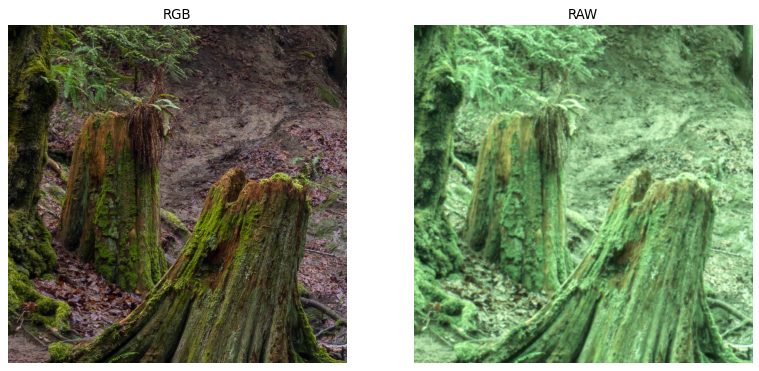

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:16<00:00,  7.32it/s]

0.0021852533022562663


In [14]:
SUBMISSION_PATH = './submission/'
runtime = []

cnt = 0
model.eval()
with torch.no_grad():
    for (rgb_batch, rgb_name) in tqdm(test_loader):
        rgb_batch = rgb_batch.to(device)
        rgb_name  = rgb_name[0].split('/')[-1].replace('.png', '')
        
        st = time.time()
        recon_raw = model(rgb_batch)
        tt = time.time() - st
        runtime.append(tt)
        
        recon_raw = recon_raw[0].detach().cpu().permute(1, 2, 0).numpy()
        rgb_batch = rgb_batch[0].detach().cpu().permute(1, 2, 0).numpy()
        
        if cnt % 100 == 0:
            plot_pair(rgb_batch, postprocess_raw(demosaic(recon_raw)))
        
        ## save as np.uint16
        assert recon_raw.shape[-1] == 4
        recon_raw = (recon_raw * 1024).astype(np.uint16)
        np.save(SUBMISSION_PATH + rgb_name + '.npy', recon_raw) 
        cnt+=1

print (np.mean(runtime)) ## add into the readme!